# Fan-in Binary Tree

Experiment: `/network/tmp1/chenant/ant/sr_trace/2021-01-31/04-11-03`

Today: February 3, 2021

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Import files

Read the dfs, filter out the LSF value function agent from the `1228` runs and use the new LSF value function agent from the `1230` runs (which has the elig traces) for comparison.

In [2]:
sfAg_in_path = '/Users/anthony/Playground/tensorboard_logs/sr_return/2021-01-31/04-11-03/small_progress.csv'

pd_df_sep = '\|\|'

In [3]:
# LSF value function agent
sf_ag_raw_df = pd.read_csv(sfAg_in_path, sep=pd_df_sep)

/Users/anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [4]:
withDate_Data_df = sf_ag_raw_df.copy(deep=True)
print(len(withDate_Data_df))
withDate_Data_df[0:3]

2252451


,"2021-01-31 04:11:04,117",num_episodes,envCls_name,env_kwargs,agentCls_name,seed,gamma,lr,sf_lr,reward_lr,...,total_steps,cumulative_reward,v_fn_rmse,sf_G_rmse,sf_matrix_rmse,reward_vec_rmse,value_loss_avg,reward_loss_avg,sf_loss_avg,et_loss_avg
0,"2021-01-31 04:11:04,162",400,FanInBinaryTreeEnv,"{'depth': 5, 'terminal_reward_stdev': 0.1}",SFReturnAgent,2,0.9,0.01,0.01,0.01,...,5,0.947725,0.726559,0.726559,0.0,0.177903,0.179637,0.005795,0.0,None
1,"2021-01-31 04:11:04,183",400,FanInBinaryTreeEnv,"{'depth': 5, 'terminal_reward_stdev': 0.1}",SFReturnAgent,2,0.9,0.01,0.01,0.01,...,5,0.755853,0.726229,0.726229,0.0,0.176563,0.111430,0.003594,0.0,None
2,"2021-01-31 04:11:04,203",400,FanInBinaryTreeEnv,"{'depth': 5, 'terminal_reward_stdev': 0.1}",SFReturnAgent,2,0.9,0.01,0.01,0.01,...,5,1.179971,0.725718,0.725718,0.0,0.174474,0.270574,0.008727,0.0,None


#### Manually drop the date time column

In [5]:
Data_df = withDate_Data_df.copy(deep=True)
del Data_df['2021-01-31 04:11:04,117']
print(list(Data_df))
print(len(Data_df))
Data_df[0:3]

['num_episodes', 'envCls_name', 'env_kwargs', 'agentCls_name', 'seed', 'gamma', 'lr', 'sf_lr', 'reward_lr', 'lamb', 'eta_trace', 'use_true_reward_params', 'use_true_sf_params', 'episode_idx', 'total_steps', 'cumulative_reward', 'v_fn_rmse', 'sf_G_rmse', 'sf_matrix_rmse', 'reward_vec_rmse', 'value_loss_avg', 'reward_loss_avg', 'sf_loss_avg', 'et_loss_avg']
2252451


,num_episodes,envCls_name,env_kwargs,agentCls_name,seed,gamma,lr,sf_lr,reward_lr,lamb,...,total_steps,cumulative_reward,v_fn_rmse,sf_G_rmse,sf_matrix_rmse,reward_vec_rmse,value_loss_avg,reward_loss_avg,sf_loss_avg,et_loss_avg
0,400,FanInBinaryTreeEnv,"{'depth': 5, 'terminal_reward_stdev': 0.1}",SFReturnAgent,2,0.9,0.01,0.01,0.01,0.0,...,5,0.947725,0.726559,0.726559,0.0,0.177903,0.179637,0.005795,0.0,None
1,400,FanInBinaryTreeEnv,"{'depth': 5, 'terminal_reward_stdev': 0.1}",SFReturnAgent,2,0.9,0.01,0.01,0.01,0.0,...,5,0.755853,0.726229,0.726229,0.0,0.176563,0.111430,0.003594,0.0,None
2,400,FanInBinaryTreeEnv,"{'depth': 5, 'terminal_reward_stdev': 0.1}",SFReturnAgent,2,0.9,0.01,0.01,0.01,0.0,...,5,1.179971,0.725718,0.725718,0.0,0.174474,0.270574,0.008727,0.0,None


## Parameter study: TD(0) and KSF

### Helper method
Get an episode error, as average over past n episodes

In [6]:
def get_RMSE_summed_over_episodes(in_df):
    """
    Helper method, computes sum over all RMSEs (i.e. area under
    the curve) given independent columns
    """
    # 
    df = in_df.copy(deep=True)
    
    # ==
    # Filter for episodes
    df = df[df['episode_idx'] < 100]
    
    # ==
    # Select for independent columns
    not_indep_cols = ['episode_idx', 'total_steps', 'cumulative_reward', 
                      'v_fn_rmse', 'sf_G_rmse','sf_matrix_rmse',
                      'reward_vec_rmse', 'value_loss_avg', 
                      'reward_loss_avg','sf_loss_avg', 'et_loss_avg']
    indep_cols = [c for c in list(df) if c not in not_indep_cols]
    
    # ==
    sum_df = df.groupby(indep_cols).sum().reset_index()
    
    # ==
    # Sum over selected portions of episode
    return sum_df
    
    
    
episSummed_df = get_RMSE_summed_over_episodes(Data_df)
print(len(episSummed_df))
episSummed_df[0:1]

27469


,num_episodes,envCls_name,env_kwargs,agentCls_name,seed,gamma,lr,sf_lr,reward_lr,lamb,...,episode_idx,total_steps,cumulative_reward,v_fn_rmse,sf_G_rmse,sf_matrix_rmse,reward_vec_rmse,value_loss_avg,reward_loss_avg,sf_loss_avg
0,400,FanInBinaryTreeEnv,"{'depth': 5, 'terminal_reward_stdev': 0.1}",SFReturnAgent,2,0.9,0.01,0.01,0.01,0.0,...,2874,380,75.405864,54.202405,54.202405,0.0,9.53802,8.890786,0.25329,0.0


In [7]:
def get_RMSE_epis_averaged(in_df, episode_num=200, average_window=200):
    """
    Helper method
    """
    # 
    df = in_df.copy(deep=True)
    
    # ==
    # Filter for episodes
    range_left = episode_num - average_window
    df = df[df['episode_idx'] >= range_left]
    df = df[df['episode_idx'] < episode_num]
    
    # ==
    # Select for independent columns
    not_indep_cols = ['episode_idx', 'total_steps', 'cumulative_reward', 
                      'v_fn_rmse', 'sf_G_rmse','sf_matrix_rmse',
                      'reward_vec_rmse', 'value_loss_avg', 
                      'reward_loss_avg','sf_loss_avg', 'et_loss_avg']
    indep_cols = [c for c in list(df) if c not in not_indep_cols]
    
    # ==
    avg_df = df.groupby(indep_cols).mean().reset_index()
    avg_df['episode_idx'] = [(episode_num-1)] * len(avg_df)
    return avg_df

episAvg_df = get_RMSE_epis_averaged(Data_df, 100, 100)    
print(len(episAvg_df))
episAvg_df[0:2]

27469


,num_episodes,envCls_name,env_kwargs,agentCls_name,seed,gamma,lr,sf_lr,reward_lr,lamb,...,episode_idx,total_steps,cumulative_reward,v_fn_rmse,sf_G_rmse,sf_matrix_rmse,reward_vec_rmse,value_loss_avg,reward_loss_avg,sf_loss_avg
0,400,FanInBinaryTreeEnv,"{'depth': 5, 'terminal_reward_stdev': 0.1}",SFReturnAgent,2,0.9,0.01,0.01,0.01,0.0,...,99,5.0,0.992182,0.713190,0.713190,0.0,0.1255,0.116984,0.003333,0.0
1,400,FanInBinaryTreeEnv,"{'depth': 5, 'terminal_reward_stdev': 0.1}",SFReturnAgent,2,0.9,0.01,0.01,0.01,0.0,...,99,5.0,0.992182,0.703074,0.703074,0.0,0.1255,0.111871,0.003333,0.0


In [9]:
set(episAvg_df['env_kwargs'])

{"{'depth': 5, 'terminal_reward_stdev': 0.1}",
 "{'depth': 5, 'terminal_reward_stdev': 1.0}",
 "{'depth': 5, 'terminal_reward_stdev': 10.0}",
 "{'depth': 5, 'terminal_reward_stdev': 2.0}",
 "{'depth': 5, 'terminal_reward_stdev': 5.0}"}

In [11]:
print('lamb', set(episAvg_df['lamb']))
print('eta_trace', set(episAvg_df['eta_trace']))
print('lr', set(episAvg_df['lr']))
print('sf_lr', set(episAvg_df['sf_lr']))
print('reward_lr', set(episAvg_df['reward_lr']))
print('seed', set(episAvg_df['seed']))

lamb {0.0, 0.5, 0.3, 0.9, 0.7, 1.0}
eta_trace {0.0, 0.5, 0.9, 1.0, 0.7}
lr {0.1, 0.01, 0.2, 0.3}
sf_lr {0.1, 0.01, 0.2, 0.3}
reward_lr {0.1, 0.01, 0.2, 0.3}
seed {2, 4, 6}


### Plot parameter study

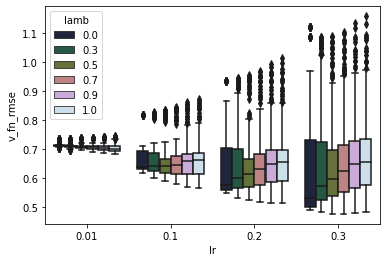

In [12]:
def lr_rmse_boxplot(data, x='lr', y='v_fn_rmse', hue='lamb', filters=None):
    # ==
    
    # ==
    # Filters
    if filters is None:
        filters = {
            'agentCls_name': 'SFReturnAgent',
            'eta_trace': 0.0,
            'use_true_sf_params': False,
            'use_true_reward_params': False,
        }
    
    df = data.copy(deep=True)
    for k in filters:
        df = df[df[k] == filters[k]]
    
    # round
    df[hue] = [round(e, 3) for e in df[hue]]
    # hues
    n_hues = len(set(df[hue].values))
    c_palette = sns.color_palette("cubehelix", n_hues) 
    
    
    sns.boxplot(x=x, y=y, hue=hue,
                 palette=c_palette,
                 data=df)
    
lr_rmse_boxplot(episAvg_df)  # example

No elig trace, LSF, fixed noise, reward and SF learning rates

In [18]:
lr_rmse_boxplot(
    episAvg_df, x='lr', y='v_fn_rmse', hue='lamb',
    filters={
        'agentCls_name': 'SFReturnAgent',
        'env_kwargs': "{'depth': 5, 'terminal_reward_stdev': 1.0}",,
        'lamb': 0.5,
        'eta_trace': 0.0,
        'use_true_sf_params': False,
        'use_true_reward_params': False,
    }
)

ValueError: min() arg is an empty sequence

Trace, no LSF, fixed noise

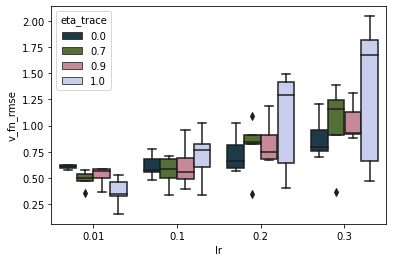

In [27]:
lr_rmse_boxplot(
    episAvg_df, x='lr', y='v_fn_rmse', hue='eta_trace',
    filters={
        'agentCls_name': 'SFReturnAgent',
        'env_kwargs': "{'n_states': 13, 'skip_prob': 0.1, 'terminal_reward_stdev': 5.0}",
        'lamb': 0.0,
        'use_true_sf_params': False,
        'use_true_reward_params': False,
    }
)

Fixed noise and lr, view trace and LSF

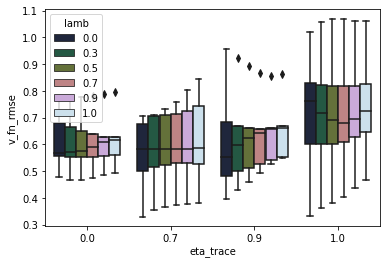

In [31]:
lr_rmse_boxplot(
    episAvg_df, x='eta_trace', y='v_fn_rmse', hue='lamb',
    filters={
        'agentCls_name': 'SFReturnAgent',
        'env_kwargs': "{'n_states': 13, 'skip_prob': 0.1, 'terminal_reward_stdev': 5.0}",
        'lr': 0.1,
        'use_true_sf_params': False,
        'use_true_reward_params': False,
    }
)

Plot across episodes

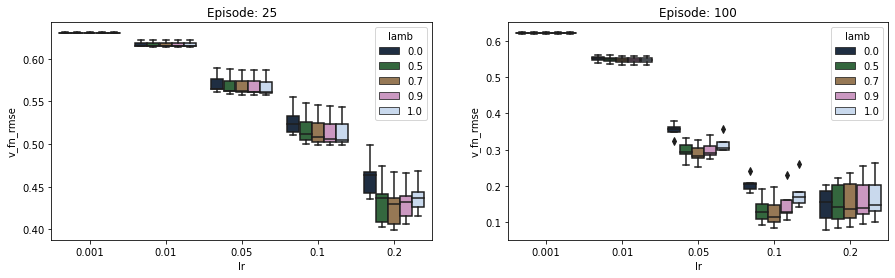

In [66]:
def script_plot_lr_rmse_boxplot_over_training(in_df, filters=None):
    # ==
    # s
    df = in_df.copy(deep=True)
    
    epis_to_plot = [25,100]
    avg_window_len = 25
    
    plt.figure(figsize=(15,4))
    
    for i, cur_epis_num in enumerate(epis_to_plot):
        cur_avg_df = get_RMSE_epis_averaged(df, episode_num=cur_epis_num, 
                                            average_window=avg_window_len)
        
        plt.subplot(1,len(epis_to_plot), i+1)
        lr_rmse_boxplot(cur_avg_df, y='v_fn_rmse', filters=filters)
        plt.title(f'Episode: {cur_epis_num}')
    
    
script_plot_lr_rmse_boxplot_over_training(Data_df)

#### Helper method to get the best parameter of the averaged RMSEs

In [111]:
def get_averaged_best_rmse_param_df(in_df, filters=None):
    dep_col = 'v_fn_rmse'
    indep_cols = ['agentCls_name', 'lamb', 'eta_trace', 
                  'use_true_sf_params', 'use_true_reward_params']
    search_cols = ['lr']
    
    # NOTE: no `lr` b.c. we want to find the best
    epis_to_plot = [25, 100]
    avg_window_len = 25
    
    
    # ==
    # Search for best parameters 
    df = in_df.copy(deep=True)
    df_list = []
    
    for i, cur_epis_num in enumerate(epis_to_plot):
        cur_avg_df = get_RMSE_epis_averaged(df, episode_num=cur_epis_num, 
                                            average_window=avg_window_len)
        cur_idx = (cur_avg_df.groupby(indep_cols)[dep_col].transform(min) 
                   == cur_avg_df[dep_col])
        
        
        cur_filter_df = cur_avg_df[cur_idx].reset_index()
        idxs = (pd.merge(cur_avg_df, cur_filter_df, 
                         on=(indep_cols + search_cols), how='left', 
                         indicator=True)['_merge'] 
                == 'both')
        
        df_list.append(cur_avg_df[idxs])
    
    best_df = pd.concat(df_list, ignore_index=True)
    
    return best_df
    

avg_best_param_df = get_averaged_best_rmse_param_df(Data_df)
print(len(avg_best_param_df))
avg_best_param_df[0:2]

50


,num_episodes,envCls_name,env_kwargs,agentCls_name,seed,gamma,lr,lamb,eta_trace,use_true_reward_params,...,episode_idx,total_steps,cumulative_reward,v_fn_rmse,sf_G_rmse,sf_matrix_rmse,reward_vec_rmse,value_loss_avg,reward_loss_avg,sf_loss_avg
0,100,SimpleLinearChainEnv,"{'n_states': 13, 'skip_prob': 0.1, 'terminal_r...",SFReturnAgent,2,0.9,0.2,0.0,0.0,False,...,24,11.92,0.931691,0.442779,0.442779,0.000000,0.096227,0.177989,0.01179,0.000000
1,100,SimpleLinearChainEnv,"{'n_states': 13, 'skip_prob': 0.1, 'terminal_r...",SFReturnAgent,2,0.9,0.2,0.5,0.0,False,...,24,11.92,0.931691,0.408446,0.392892,0.037085,0.096227,0.180525,0.01179,0.166269


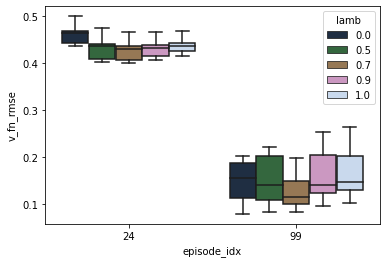

In [114]:
def script_plt_best_param_boxplot(best_df):
    # ==
    plt_x = 'episode_idx'
    plt_y = 'v_fn_rmse'
    plt_hue = 'lamb'
    
    filters = {
        'agentCls_name': 'SFReturnAgent',
        'eta_trace': 0.0,
        'use_true_sf_params': False,
        'use_true_reward_params': False,
    }
    
    df = best_df.copy(deep=True)
    for k in filters:
        df = df[df[k] == filters[k]]
    
    # round
    df[plt_hue] = [round(e, 3) for e in df[plt_hue]]
    # hues
    n_hues = len(set(df[plt_hue].values))
    c_palette = sns.color_palette("cubehelix", n_hues) 
    
    
    sns.boxplot(x=plt_x, y=plt_y, hue=plt_hue,
                 palette=c_palette,
                 data=df)
    
    
script_plt_best_param_boxplot(avg_best_param_df)

In [123]:
def script_helper_get_best_param_for_episode(best_df, episode_idx):
    indep_cols = ['agentCls_name', 'lamb', 'eta_trace', 
                  'use_true_sf_params', 'use_true_reward_params', 'lr']
    
    df = best_df.copy(deep=True)
    df = df[df['episode_idx'] == episode_idx]
    
    return df.groupby(indep_cols).mean()

script_helper_get_best_param_for_episode(avg_best_param_df, 99)

num_episodes  \
agentCls_name lamb eta_trace use_true_sf_params use_true_reward_params lr                  
SFReturnAgent 0.0  0.0       False              False                  0.2           100   
              0.5  0.0       False              False                  0.2           100   
              0.7  0.0       False              False                  0.1           100   
              0.9  0.0       False              False                  0.2           100   
              1.0  0.0       False              False                  0.2           100   

                                                                            seed  \
agentCls_name lamb eta_trace use_true_sf_params use_true_reward_params lr          
SFReturnAgent 0.0  0.0       False              False                  0.2     6   
              0.5  0.0       False              False                  0.2     6   
              0.7  0.0       False              False                  0.1     6   
              0.9  0.0       False              False                  0.2     6   
              1.0  0.0       False              False                  0.2     6   

                                                                            gamma  \
agentCls_name lamb eta_trace use_true_sf_params use_true_reward_params lr           
SFReturnAgent 0.0  0.0       False              False                  0.2    0.9   
              0.5  0.0       False              False                  0.2    0.9   
              0.7  0.0       False              False                  0.1    0.9   
              0.9  0.0       False              False                  0.2    0.9   
              1.0  0.0       False              False                  0.2    0.9   

                                                                            episode_idx  \
agentCls_name lamb eta_trace use_true_sf_params use_true_reward_params lr                 
SFReturnAgent 0.0  0.0       False              False                  0.2           99   
              0.5  0.0       False              False                  0.2           99   
              0.7  0.0       False              False                  0.1           99   
              0.9  0.0       False              False                  0.2           99   
              1.0  0.0       False              False                  0.2           99   

                                                                            total_steps  \
agentCls_name lamb eta_trace use_true_sf_params use_true_reward_params lr                 
SFReturnAgent 0.0  0.0       False              False                  0.2        12.04   
              0.5  0.0       False              False                  0.2        12.04   
              0.7  0.0       False              False                  0.1        12.04   
              0.9  0.0       False              False                  0.2        12.04   
              1.0  0.0       False              False                  0.2        12.04   

                                                                            cumulative_reward  \
agentCls_name lamb eta_trace use_true_sf_params use_true_reward_params lr                       
SFReturnAgent 0.0  0.0       False              False                  0.2           0.954478   
              0.5  0.0       False              False                  0.2           0.954478   
              0.7  0.0       False              False                  0.1           0.954478   
              0.9  0.0       False              False                  0.2           0.954478   
              1.0  0.0       False              False                  0.2           0.954478   

                                                                            v_fn_rmse  \
agentCls_name lamb eta_trace use_true_sf_params use_true_reward_params lr               
SFReturnAgent 0.0  0.0       False              False                  0.2   0.147619   
              0.5  0.0 

### Plot learning dynamics
Given the best paramters

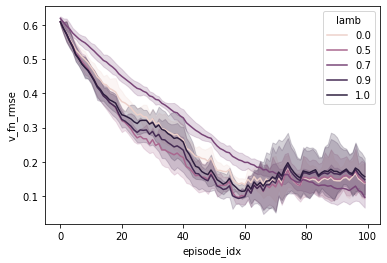

In [127]:
def script_plt_learning_over_epis(in_data_df, in_best_df, filters=None):
    indep_cols = ['agentCls_name', 'lamb', 'eta_trace', 'lr',
                  'use_true_sf_params', 'use_true_reward_params']
    
    
    df = in_data_df.copy(deep=True)
    # TODO filter
    best_df = in_best_df.copy(deep=True)
    
    # Filter the oriingla full df with just the best params
    best_param_df = script_helper_get_best_param_for_episode(best_df, episode_idx=99)
    idxs = (pd.merge(df, best_param_df, 
                         on=indep_cols, how='left', 
                         indicator=True)['_merge'] 
                == 'both')
    df = df[idxs]
    
    # ==
    # Plot
    sns.lineplot(x='episode_idx', y='v_fn_rmse', hue='lamb', data=df)
    
    
script_plt_learning_over_epis(Data_df, avg_best_param_df)

## Simpler plot: fixed lr

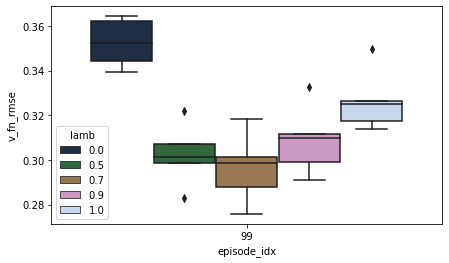

In [141]:
def script_boxplot_fixed_lr(in_df, filters=None):
    # ==
    # s
    df = in_df.copy(deep=True)
    
    epis_to_plot = [100]
    avg_window_len = 100
    
    
    
    df_list = []
    for i, cur_epis_num in enumerate(epis_to_plot):
        cur_avg_df = get_RMSE_epis_averaged(df, episode_num=cur_epis_num, 
                                            average_window=avg_window_len)
        df_list.append(cur_avg_df)


    plt.figure(figsize=(7,4))
    lr_rmse_boxplot(cur_avg_df, x='episode_idx', y='v_fn_rmse', hue='lamb', filters=filters)
        
script_boxplot_fixed_lr(
    Data_df, 
    filters={'agentCls_name': 'SFReturnAgent',
             'lr': 0.1,
             'eta_trace': 0.0,
             'use_true_sf_params': False,
             'use_true_reward_params': False,
            }
)

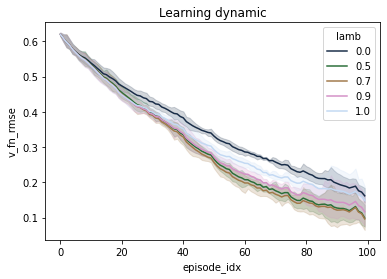

In [152]:
def episode_rmse_lineplot(data, y='v_fn_rmse', filters=None):
    # ==
    plt_x = 'episode_idx'
    plt_hue = 'lamb'
    plt_ci = 95
    plt_n_boot = 200
    
    # ==
    # Filters
    if filters is None:
        filters = {
            'agentCls_name': 'SFReturnAgent',
            'eta_trace': 0.0,
            'use_true_sf_params': False,
            'use_true_reward_params': False,
        }
    
    df = data.copy(deep=True)
    for k in filters:
        df = df[df[k] == filters[k]]
    
    # round
    df[plt_hue] = [round(e, 3) for e in df[plt_hue]]
    # hues
    n_hues = len(set(df[plt_hue].values))
    c_palette = sns.color_palette("cubehelix", n_hues) 
    
    
    sns.lineplot(x=plt_x, y=y, hue=plt_hue,
                 ci=plt_ci, n_boot=plt_n_boot, 
                 palette=c_palette, 
                 data=df)
    plt.title('Learning dynamic')
    
episode_rmse_lineplot(
    Data_df, 
    filters={'agentCls_name': 'SFReturnAgent',
             'lr': 0.1,
             'eta_trace': 0.0,
             'use_true_sf_params': False,
             'use_true_reward_params': False,
            }
) 